# Evaluating VGG16 trained to detect defects in steel sheet 


The model has been trained on a dataset of 8798 images with 3770 images as validation. The pre-trained, but not freezed, VGG16 with Batch Normalization module has been used as feature extractor, then a FNN with three layers (dropout and ReLU activation function) .

The final structure:
    
    VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace=True)
        (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (16): ReLU(inplace=True)
        (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (19): ReLU(inplace=True)
        (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (22): ReLU(inplace=True)
        (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (24): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (26): ReLU(inplace=True)
        (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (29): ReLU(inplace=True)
        (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (32): ReLU(inplace=True)
        (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (36): ReLU(inplace=True)
        (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (39): ReLU(inplace=True)
        (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (42): ReLU(inplace=True)
        (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (avgpool): Flatten()
      (classifier): Sequential(
        (0): Linear(in_features=12288, out_features=256, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=256, out_features=32, bias=True)
        (4): ReLU(inplace=True)
        (5): Dropout(p=0.5, inplace=False)
        (6): Linear(in_features=32, out_features=2, bias=True)
      )
    )

### 1. Requirments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import cv2
import torch
import shap
import captum

import src.utils as c_utils
import src.dataset as c_dataset

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

### 2. Parameters

In [2]:
DATA_PATH = 'data/binaryData'
MODEL_PATH = 'model/BinaryVGG16.pth'
IMAGE_PATH = 'data/train_images'
METADATA_PATH = 'data/binaryData/val_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_val_binary1.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_val_binary1.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_val_binary1.pth'

In [3]:
N_CLASSES = 2
params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Important Procedure: to run if 'data/binaryData' does not exists (otherwise skip)

Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly.

In [4]:
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]):
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [5]:
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Starting process to create matrices...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:12<00:00,  6.97s/it]


### 3.2 Load and visualize data

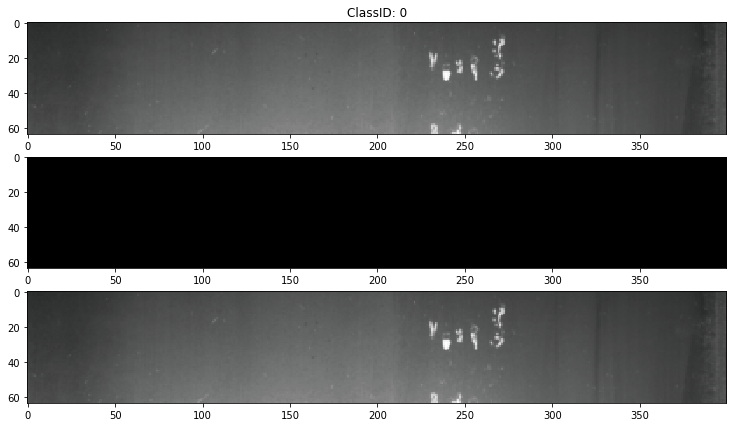

In [6]:
n = 0

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
mask = M_val[n].reshape(*params['size'])
ax[0].set_title('ClassID: {}'.format(y_val[n]))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
img[mask == 1] = img[mask == 1] + params['colors'][y_val[n]]
ax[2].imshow(img)
plt.show()

### 4. Model

In [7]:
### 4.1 Load architecture
vgg16 = models.vgg16_bn(pretrained=True)
vgg16.avgpool = nn.Flatten()
vgg16.classifier = nn.Sequential(nn.Linear(in_features=12288, out_features=256, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=256, out_features=32, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=32, out_features=N_CLASSES, bias=True))
net = vgg16.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [8]:
y_pred = []
y_true = []
y_score = []
batch_size = 5

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
     
        y_score = np.concatenate([y_score, nn.Softmax(dim=1)(out).detach().cpu().numpy().reshape(-1)])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])

100%|████████████████████████████████████████████████████████████████████████████████| 754/754 [02:11<00:00,  5.73it/s]


In [9]:
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('F1 Score: {}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9363395225464191
F1 Score: 0.9360847953018087


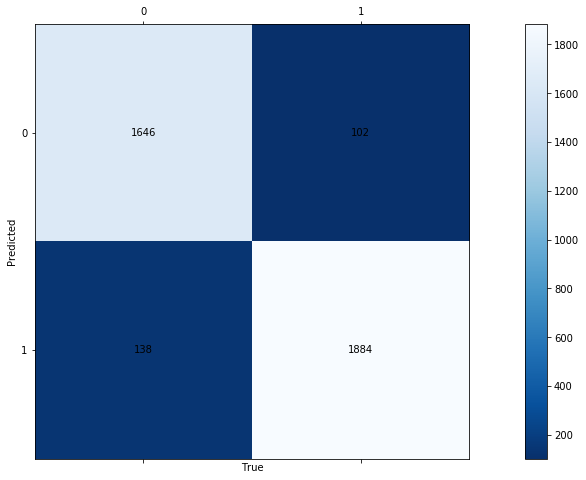

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

cm = confusion_matrix(y_pred, y_true)
cm_plot = ax.matshow(cm, cmap='Blues_r')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.colorbar(cm_plot)
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        k = 0
        ax.text(j, i, cm[i, j], va='center', ha='center')